In [1]:
import keras
from keras.layers import Conv2D, Conv3D, MaxPool3D, MaxPool2D, concatenate, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.utils import plot_model


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
!pip install spectral
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [0]:
data = sio.loadmat('/content/KSC.mat')['KSC']
labels = sio.loadmat('/content/KSC_gt.mat')['KSC_gt']

In [0]:
test_ratio = 0.7
windowSize = 25

In [0]:
def TrainTestSplit(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [0]:
def dim_reduce_PCA(X, numComponents):
    dim_reduce_X = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    dim_reduce_X = pca.fit_transform(dim_reduce_X)
    dim_reduce_X = np.reshape(dim_reduce_X, (X.shape[0],X.shape[1], numComponents))
    return dim_reduce_X, pca

In [0]:
def ZeroPadding(X, border_offset=2):
    ZeroPadding_X = np.zeros((X.shape[0] + 2 *(border_offset), X.shape[1] + 2*(border_offset), X.shape[2]))
    x_offset = border_offset
    y_offset = border_offset
    ZeroPadding_X[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return ZeroPadding_X

In [0]:
def PixelwiseInput(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    ZeroPadding_X = ZeroPadding(X, border_offset=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, ZeroPadding_X.shape[0] - margin):
        for c in range(margin, ZeroPadding_X.shape[1] - margin):
            patch = ZeroPadding_X[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [0]:
X = data
y = labels

In [0]:
K=15
X,pca = dim_reduce_PCA(X,numComponents=K)

In [0]:
X, y = PixelwiseInput(X, y, windowSize=windowSize)

In [0]:
Xtrain, Xtest, ytrain, ytest = TrainTestSplit(X, y, test_ratio)

In [0]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K , 1)

In [0]:
ytrain = np_utils.to_categorical(ytrain)

In [0]:
S = windowSize
L = K
output_units = 13

In [0]:
def inception_module_3d(input_layer,
                     filters_1x1x1,
                     filters_3x3x3_reduce,
                     filters_3x3x3,
                     filters_3x3x5_reduce,
                     filters_3x3x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1x1 = Conv3D(filters_1x1x1, (1, 1, 1), padding='same', activation='relu')(input_layer)
    
    conv_3x3x3 = Conv3D(filters_3x3x3_reduce, (1, 1, 1), padding='same', activation='relu')(input_layer)
    conv_3x3x3 = Conv3D(filters_3x3x3, (3, 3, 3), padding='same', activation='relu')(conv_3x3x3)

    conv_3x3x5 = Conv3D(filters_3x3x5_reduce, (1, 1, 1), padding='same', activation='relu')(input_layer)
    conv_3x3x5 = Conv3D(filters_3x3x5, (3, 3, 5), padding='same', activation='relu')(conv_3x3x5)

    pool_proj = MaxPool3D((3, 3, 3), strides=(1, 1, 1), padding='same')(input_layer)
    pool_proj = Conv3D(filters_pool_proj, (1, 1, 1), padding='same', activation='relu')(pool_proj)

    output_3d = concatenate([conv_1x1x1, conv_3x3x3, conv_3x3x5, pool_proj], axis=4, name=name)
    
    return output_3d

In [0]:
def inception_module_2d(x,
                     filters_1x1,
                     filters_2x2_reduce,
                     filters_2x2,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_2x2 = Conv2D(filters_2x2_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_2x2 = Conv2D(filters_2x2, (2, 2), padding='same', activation='relu')(conv_2x2)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_2x2, conv_3x3, pool_proj], axis=3, name=name)
    
    return output

In [0]:
## Input layer
input_layer = Input((S, S, L, 1))


## Inception layers (for 3D convolution)
inception_1 = inception_module_3d(input_layer,32,48,64,8,16,16)
inception_2 = inception_module_3d(inception_1,32,48,64,8,16,16)

inception_2_shape = inception_2._keras_shape

#Inception 2D convolution
reshape_1 = Reshape((inception_2_shape[1], inception_2_shape[2], inception_2_shape[3]*inception_2_shape[4]))(inception_2)
conv_2 = inception_module_2d(reshape_1,64,64,96,16,48,32)

flatten_1 = Flatten()(conv_2)

## Dense FC Layer
dense_1 = Dense(units=256, activation='relu')(flatten_1)
dense_1 = Dropout(0.4)(dense_1)
dense_2 = Dense(units=128, activation='relu')(dense_1)
dense_2 = Dropout(0.4)(dense_2)
output_layer = Dense(units=output_units, activation='softmax')(dense_2)

In [18]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 25, 15, 1 0                                            
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 25, 25, 15, 4 96          input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_4 (Conv3D)               (None, 25, 25, 15, 8 16          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 25, 25, 15, 1 0           input_1[0][0]                    
____________________________________________________________________________________________

In [0]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
# checkpoint
filepath = "/content/best-modelindian_pines.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [21]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=100, callbacks=callbacks_list)

Epoch 1/100
1563/1563 [==============================] - 17s 11ms/step - loss: 2.1056 - accuracy: 0.3756
Epoch 2/100


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning:

Can save best model only with acc available, skipping.



1563/1563 [==============================] - 7s 5ms/step - loss: 1.1404 - accuracy: 0.6379
Epoch 3/100
1563/1563 [==============================] - 7s 5ms/step - loss: 0.8307 - accuracy: 0.7179
Epoch 4/100
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6462 - accuracy: 0.7780
Epoch 5/100
1563/1563 [==============================] - 7s 5ms/step - loss: 0.5272 - accuracy: 0.8221
Epoch 6/100
1563/1563 [==============================] - 7s 5ms/step - loss: 0.4255 - accuracy: 0.8573
Epoch 7/100
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3379 - accuracy: 0.8906
Epoch 8/100
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2731 - accuracy: 0.9079
Epoch 9/100
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2105 - accuracy: 0.9303
Epoch 10/100
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1398 - accuracy: 0.9584
Epoch 11/100
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1074

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [23]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(3648, 25, 25, 15, 1)

In [24]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(3648, 13)

In [25]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       533
           1       1.00      1.00      1.00       170
           2       1.00      0.99      1.00       179
           3       0.97      0.98      0.97       176
           4       1.00      0.98      0.99       113
           5       0.99      1.00      1.00       160
           6       1.00      1.00      1.00        74
           7       1.00      1.00      1.00       302
           8       0.99      1.00      1.00       364
           9       1.00      0.99      0.99       283
          10       1.00      1.00      1.00       293
          11       1.00      1.00      1.00       352
          12       1.00      1.00      1.00       649

    accuracy                           1.00      3648
   macro avg       1.00      1.00      1.00      3648
weighted avg       1.00      1.00      1.00      3648



In [0]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [0]:
def reports (X_test,y_test):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
   
    target_names = ['Scrub', 'Willow swamp', 'Cabbage palm hammock', 'Cabbage palm/oak hammock'
                        ,'Slash pine', 'Oak/broadleaf hammock', 'Hardwood Swamp', 
                        'Graminoid marsh', 'Spartina marsh', 'Cattail marsh', 'Salt marsh',
                        'Mud flats', 'Water']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [28]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report_ksc.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

3648/3648 [==============================] - 5s 1ms/step


In [0]:

def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch


In [0]:
X = sio.loadmat('/content/KSC.mat')['KSC']
y = sio.loadmat('/content/KSC_gt.mat')['KSC_gt']

height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [0]:
X,pca = dim_reduce_PCA(X, numComponents=numComponents)

In [0]:

X = ZeroPadding(X, PATCH_SIZE//2)

In [0]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

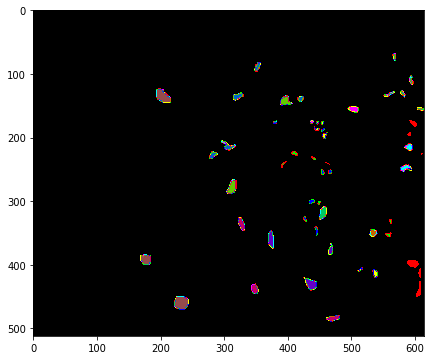

In [34]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

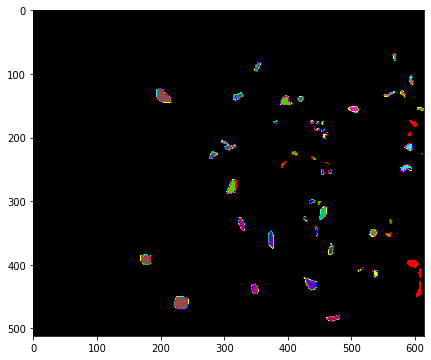

In [35]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))